In [13]:
import numpy as np, math
from sklearn.mixture import GaussianMixture
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from scipy.stats import norm
from astropy.stats import bayesian_blocks, knuth_bin_width, histogram

import random

from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from scipy import interpolate

import os.path

font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 14}

In [20]:
from astropy.table import Table
# Simulated CMD having a total number of main-sequence systems as the number of selected main-sequence systems in the
# observed CMD of the OC:
t = Table.read("data/NGC_6494_sel_MS_members_sim_9.txt", format="ascii")

t["BP-RP"] = t["Bp"] - t["Rp"]

# For when there was the error of the bianries having DistMod=9999.00000:
# for i in np.arange(len(t)):
#    if t["DistMod"][i] == 9999.00000:
#        t["DistMod"][i] = t["DistMod"][0]

# Create a new column added to the loaded table t with the intrinsic G magnitude
#   Gmag is Gaia's G magnitude
#   DMNN is the distance modulus in magnitudes
#   AVNN is the visual extinction and it's correccted by the factor 0.89 to obtain the extinction in the G passband
t["MG"] = t["G"] - t["DistMod"] - 0.89*t["Av"]

# New column with intrinsic BP-RP (de-reddened)
t["BP-RP_0"] = t["BP-RP"] - (0.89/1.85)*t["Av"]

print(t.columns)
print(len(t))

<TableColumns names=('ClusterName','#ID','Mass','LogTeff','Logg','Av','Log age','DistMod','G','sigG','Bp','sigBp','Rp','sigRp','BP-RP','MG','BP-RP_0','BP-RP_0_lim','allDeltas')>
682


In [18]:
#File containing the simulated OC with a total mass of 10^4 M_Sun, with the generated systems and their characteristics
#(without specifying if the multiple systems are observed to be resolved or unresolved: this is not the simulated
#OC with a total mass of 10^4 M_Sun as seen by Gaia).
t_Universe_model = Table.read("data/NGC_6494_all_mem_UniverseModel_sim_9.txt", format="csv")

In [19]:
t_Universe_model

#ClusterName,#ID,Mass,LogTeff,Logg,Av,Log age,DistMod,G,Bp,Rp
str8,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC_6494,2273987966923702273,0.90676,3.732,4.591,1.23818,8.57978,9.35202,15.64463,16.29716,14.82764
NGC_6494,2273987966923702274,0.32493,3.5079,4.937,1.33009,8.57978,9.35202,20.97578,22.94589,19.57895
NGC_6494,2273987967057920004*,9999.0,9999.0,9999.0,1.35479,8.57978,9.35202,19.66005,21.49241,18.29519
NGC_6494,2273987967057920004A,0.36063,3.5158,4.911,1.35479,8.57978,9.35202,20.42891,22.26525,19.06307
NGC_6494,2273987967057920004B,0.357,3.561,4.9,1.35479,8.57978,9.35202,20.39658,22.22509,19.03268
NGC_6494,2273987967057920007*,9999.0,9999.0,9999.0,1.27028,8.57978,9.35202,20.15284,22.05373,18.7711
NGC_6494,2273987967057920007A,0.36875,3.5177,4.903,1.27028,8.57978,9.35202,20.44535,22.27318,19.08162
NGC_6494,2273987967057920007B,0.209,3.531,4.937,1.27028,8.57978,9.35202,21.7198,23.89756,20.28175
NGC_6494,2273987966923702281,1.02835,3.7666,4.52,1.41933,8.57978,9.35202,15.4455,16.09626,14.62991


In [8]:
cluslist = np.unique(t["ClusterName"])

print("Total number of simulated OCs:", len(cluslist))

Total number of simulated OCs: 1


In [22]:
t["mass_ratio"]=np.zeros(len(t))

print(t)

ClusterName         #ID            Mass  ...       allDeltas       mass_ratio
----------- -------------------- ------- ... --------------------- ----------
   NGC_6494 2273987967057923605A 0.66645 ...   0.01849499461815096        0.0
   NGC_6494  2273987966923707636 0.65147 ... -0.003981433232801201        0.0
   NGC_6494  2273987966923706379 0.75082 ...    0.0473868207764383        0.0
   NGC_6494 2273987967057931544*  9999.0 ...   -0.5909282110377037        0.0
   NGC_6494  2273987966923706463  1.3913 ...  -0.02252563800799834        0.0
   NGC_6494 2273987967057932404*  9999.0 ... -0.023619726748545844        0.0
   NGC_6494  2273987966923710320 0.93053 ... -0.004993168157118255        0.0
   NGC_6494 2273987967057925685*  9999.0 ...  -0.11261997325945661        0.0
   NGC_6494 2273987967057932546*  9999.0 ...  -0.07640938171669376        0.0
   NGC_6494 2273987967057929495*  9999.0 ... -0.011859645467286128        0.0
        ...                  ...     ... ...                   .

In [10]:
print(t_Universe_model)

#ClusterName         #ID            Mass  LogTeff ...    G        Bp       Rp   
------------ -------------------- ------- ------- ... -------- -------- --------
    NGC_6494  2273987966923702273 0.90676   3.732 ... 15.64463 16.29716 14.82764
    NGC_6494  2273987966923702274 0.32493  3.5079 ... 20.97578 22.94589 19.57895
    NGC_6494 2273987967057920004*  9999.0  9999.0 ... 19.66005 21.49241 18.29519
    NGC_6494 2273987967057920004A 0.36063  3.5158 ... 20.42891 22.26525 19.06307
    NGC_6494 2273987967057920004B   0.357   3.561 ... 20.39658 22.22509 19.03268
    NGC_6494 2273987967057920007*  9999.0  9999.0 ... 20.15284 22.05373  18.7711
    NGC_6494 2273987967057920007A 0.36875  3.5177 ... 20.44535 22.27318 19.08162
    NGC_6494 2273987967057920007B   0.209   3.531 ...  21.7198 23.89756 20.28175
    NGC_6494  2273987966923702281 1.02835  3.7666 ...  15.4455 16.09626 14.62991
    NGC_6494 2273987967057920011*  9999.0  9999.0 ... 21.49188 23.76282 20.03656
         ...                

In [11]:
print(len(np.unique(t_Universe_model["#ClusterName"])))

1


Number of systems in the simulated CMD: 682
Number of unresolved systems in the simulated CMD: 270
Number of resolved systems in the simulated CMD: 94
Number of single systems in the simulated CMD: 318


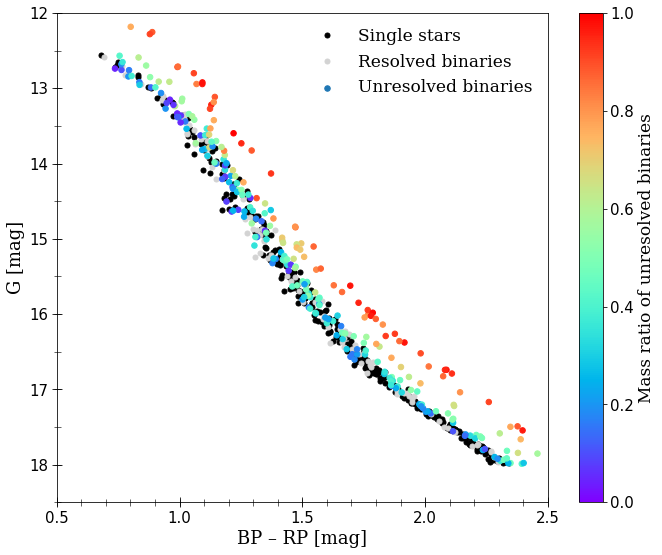

In [25]:
for ii in np.arange(len(cluslist)):
    rowset = t[ (t["ClusterName"]  == cluslist[ii]) ]
    rowset_Universe_model = t_Universe_model[ (t_Universe_model["#ClusterName"]  == cluslist[ii])  ]
   
    unresolved_list_indices = []
    resolved_list_indices = []
    simple_list_indices = []
    
    for jj in np.arange(len(rowset)):
        
        if "*" in rowset["#ID"][jj]:
           # nb_tot_sel_unresolved = nb_tot_sel_unresolved + 1
           # sel_binaries_list.append(rowset["#ID"][i])
            more_massive_star = str((rowset["#ID"][jj])[:-1])+str("A")
            t_more_massive = rowset_Universe_model[ (rowset_Universe_model["#ID"] == more_massive_star) ]
            mass_more_massive_star = t_more_massive["Mass"][0]
            less_massive_star = str((rowset["#ID"][jj])[:-1])+str("B")
            t_less_massive = rowset_Universe_model[ (rowset_Universe_model["#ID"] == less_massive_star) ]
            mass_less_massive_star = t_less_massive["Mass"][0]
            mass_ratio = (mass_less_massive_star)/(mass_more_massive_star)
            (rowset["mass_ratio"][jj]) = mass_ratio
            unresolved_list_indices.append(jj)

        elif ("A" in rowset["#ID"][jj]) or ("B" in rowset["#ID"][jj]):  #if in here there is if instead of elif, nb_tot_simples is not well calculated
            (rowset["mass_ratio"][jj]) = -1.0   # They are resolved binary systems
            resolved_list_indices.append(jj)
        else:
            (rowset["mass_ratio"][jj]) = 0.0   # They are single stars
            simple_list_indices.append(jj)
    print("Number of systems in the simulated CMD:", len(rowset))
    
    rowset_unresolved = rowset[unresolved_list_indices]
    print("Number of unresolved systems in the simulated CMD:", len(rowset_unresolved))
    rowset_resolved = rowset[resolved_list_indices]
    print("Number of resolved systems in the simulated CMD:", len(rowset_resolved))
    rowset_simple = rowset[simple_list_indices]
    print("Number of single systems in the simulated CMD:", len(rowset_simple))
    
    xpts = rowset["BP-RP"]
    ypts = rowset["G"]
    
    xpts_simples = rowset_simple["BP-RP"]
    ypts_simples = rowset_simple["G"]
    
    xpts_resolved = rowset_resolved["BP-RP"]
    ypts_resolved = rowset_resolved["G"]
    
    xpts_unresolved = rowset_unresolved["BP-RP"]
    ypts_unresolved = rowset_unresolved["G"]
        
    savename=cluslist[ii].strip()
    
  
    # Plot colour-magnitude diagram with its fitted polynomial
    plt.figure(figsize=(11,9))
    ax = plt.subplot(111)
    plt.xticks(np.arange(0.5, 3., step=0.5), fontsize=15)
    plt.yticks(np.arange(12, 19, step=1), fontsize=15)
    ax.tick_params(which="major", direction='inout', length=10.)
    ax.tick_params(which="minor", direction='inout', length=7.)
    plt.xlim(0.5, 2.5)
    plt.ylim(18.5, 12.0)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))

    # x range in which the fitted polynomial is represented:
    x = np.linspace(np.min(xpts), np.max(xpts), 100)
    plt.plot(xpts_simples, ypts_simples, 'o', color = 'black', markersize=5, label="Single stars", zorder=0)
    plt.plot(xpts_resolved, ypts_resolved, 'o', color = 'lightgrey', markersize=5, label="Resolved binaries", zorder=0)
    sc = ax.scatter(xpts_unresolved, ypts_unresolved, s=30, c=rowset_unresolved["mass_ratio"] , 
                    cmap="rainbow", label="Unresolved binaries", vmin=0, vmax=1.0)
    cb = plt.colorbar(sc)
    cb.set_label('Mass ratio of unresolved binaries', fontsize=17, fontdict=font)
    cb.ax.tick_params(labelsize=15) 

    #plt.colorbar(label="Mass ratio of unresolved binaries", ticks = np.linspace(0.0, 1.0, 6, endpoint=True))
    #plt.plot(x, p(x), '-', color = "orangered", linewidth = 1.5)
    plt.ylabel(r'G [mag]', fontsize = 18, fontdict=font)
    plt.xlabel(r'BP – RP [mag]', fontsize = 18, fontdict=font)
    plt.legend(prop={"family":"serif", 'size': 17}, edgecolor="white")
    plt.savefig("im/"+savename+"_sim_CMD_MS_sel_mem_colorbar"+"_sim9_obsCMD.png", dpi=300)
    plt.show()
    plt.close()